In [1]:
import torch
import os
import glob
from PIL import Image
import scipy
import numpy as np
import matplotlib.pyplot as plt
from typing import Optional, Union

import random

from mpl_toolkits.axes_grid1 import ImageGrid

# Background Images

In [2]:
# Download the dataset of texture images
# Dataset taken from here : https://github.com/abin24/Textures-Dataset

import gdown
gdown.download("https://drive.google.com/uc?id=13LBYN6eTfV9G9xdgZtdpNHrXSA8mpv-2", "/tmp/Splited.zip", quiet=False)

os.makedirs("/tmp/Textures", exist_ok = True)

import zipfile
with zipfile.ZipFile("/tmp/Splited.zip", 'r') as zip_ref:
    zip_ref.extractall("/tmp/Textures")

Downloading...
From: https://drive.google.com/uc?id=13LBYN6eTfV9G9xdgZtdpNHrXSA8mpv-2
To: /tmp/Splited.zip
100%|██████████| 563M/563M [00:06<00:00, 82.8MB/s]


In [3]:
background_image_root = "/tmp/Textures/train/"

bg_img_paths = glob.glob(os.path.join(background_image_root, "*/*.jpg"))
bg_imgs = [np.array(Image.open(x)) for x in bg_img_paths]

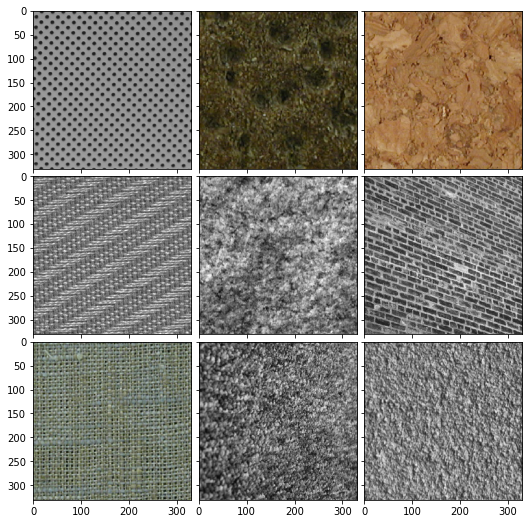

In [4]:
sample_indices = np.random.choice(len(bg_imgs), size=9, replace=False)
sample_images = np.array(bg_imgs)[sample_indices]

fig = plt.figure(figsize=(9, 9))
grid = ImageGrid(fig, 111,  
                 nrows_ncols=(3, 3),
                 axes_pad=0.1,
                 )

for ax, im in zip(grid, sample_images):
    # Iterating over the grid returns the Axes.
    ax.imshow(im)

plt.show()

# Phone Stock Photo

In [5]:
# Download the stock iphone photo
import gdown
gdown.download("https://drive.google.com/uc?id=18WckfN5c-tsZ0Qy6slEmpGOA-XOcgHlF", "/tmp/iphone.png", quiet=False)

Downloading...
From: https://drive.google.com/uc?id=18WckfN5c-tsZ0Qy6slEmpGOA-XOcgHlF
To: /tmp/iphone.png
100%|██████████| 51.0k/51.0k [00:00<00:00, 15.3MB/s]


'/tmp/iphone.png'

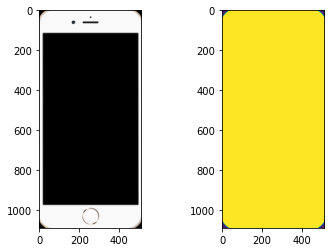

In [6]:
iphone_img_path = "/tmp/iphone.png"

img = (Image.open(iphone_img_path))
plt.subplot(1, 2, 1)
plt.imshow(np.array(img)[:,:,:3])

plt.subplot(1, 2, 2)
plt.imshow(np.array(img)[:,:,-1])

In [7]:
# it is a 4-channel RGB+Alpha image
print(img.mode, img.size)

RGBA (512, 1091)


In [8]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
# boilerplate pytorch code enforcing reproducibility
torch.manual_seed(42)
if device.type == "cuda":
    torch.cuda.manual_seed(42)
np.random.seed(42)
random.seed(42)

# Training Set
Given background images and the iphone image, we will paste the iphone onto the background images.

In [9]:
import torchvision
import torchvision.transforms as transforms

In [10]:
def random_paste(background_image, stock_image, min_scale=0.05, max_scale=0.1):
    """Randomly scales and pastes the stock image onto the background image"""
    
    background_image = background_image.resize((256, 256))

    W, H = background_image.size
    stock_image = stock_image.resize((W, 2*W))
    w, h = stock_image.size
    # first, we will randomly downscale the iphone image
    scale = random.uniform(min_scale, max_scale)
    new_w = int(scale * w)
    new_h = int(scale * h)
    resized_stock_image = stock_image.resize((new_w, new_h))

    # second, will randomly choose the locations where to paste the new image
    start_w = random.randint(new_w, W - new_w)
    start_h = random.randint(new_h, H - new_h)

    # third, will create the blank canvas of the same size as the original image
    canvas_image = Image.new('RGBA', (W, H))

    # and paste the resized iphone onto it, preserving the mask
    canvas_image.paste(resized_stock_image, (start_w, start_h), resized_stock_image)
    
    # iphone image is of mode RGBA, while background image is of mode RGB;
    # `.paste` requires both of them to be of the same type.
    background_image = background_image.copy().convert('RGBA')
    # finally, will paste the resized iphone onto the background image
    background_image.paste(resized_stock_image, (start_w, start_h), resized_stock_image)
    return background_image, canvas_image

In [11]:
training_set = []  # image, segmentation mask

for bg_image in bg_imgs:
  # paste the iphone onto background image
  aug_image, aug_mask = random_paste((Image.fromarray(bg_image)).copy(), img.copy())
  # convert PIL images to pytorch tensors
  training_pair = [
      np.array(aug_image)[:,:, :3],  # keep the rgb only
      # For the mask, we only need the last (4th) channel,
      # and we will encode the mask as boolean
      np.array(aug_mask)[:,:,-1] > 0,
  ]
  training_set.append(training_pair)

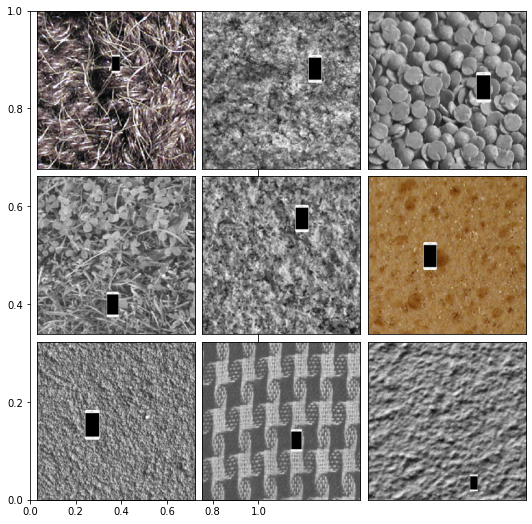

In [12]:
train_images = training_set
sample_indices = (np.random.choice(len(train_images), size=9, replace=False))

fig = plt.figure(figsize=(9, 9))

plt.subplot(1, 2, 1)
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(3, 3),  # creates 2x2 grid of axes
                 axes_pad=0.1,  # pad between axes in inch.
                 )
sample_pairs = [train_images[x] for x in sample_indices]


for (ax, pair) in (zip(grid, sample_pairs)):
    # Hide axes ticks
    ax.set_xticks([])
    ax.set_yticks([])
    # Iterating over the grid returns the Axes.
    img, mask = pair
    ax.imshow(img)

plt.show()

# Test Images
Now, let's load the test imags supplied in the dataset by Brain Corp

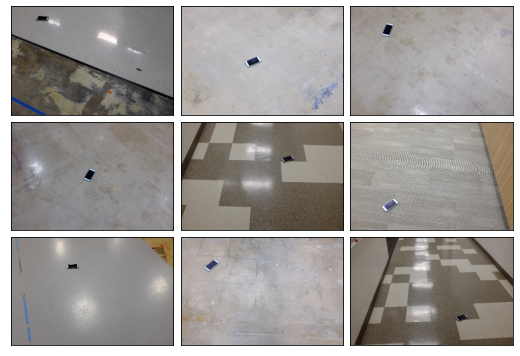

In [13]:
!git clone https://github.com/sakshamjindal/find_phone.git --quiet

test_image_root= "find_phone/find_phone"

image_paths = glob.glob(os.path.join(test_image_root, "*.jpg"))
train_images = np.array([np.array(Image.open(x)) for x in image_paths])

sample_indices = (np.random.choice(len(train_images), size=9, replace=False))
sample_images = train_images[sample_indices]

fig = plt.figure(figsize=(9, 9))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(3, 3),  # creates 2x2 grid of axes
                 axes_pad=0.1,  # pad between axes in inch.
                 )

for ax, im in zip(grid, sample_images):
    # Hide axes ticks
    ax.set_xticks([])
    ax.set_yticks([])
    # Iterating over the grid returns the Axes.
    ax.imshow(im)

plt.show()

# Prepating the dataset and training the model

### Step 0: Split the dataset

Here we split the training set generated above into train and validation set

In [14]:
from sklearn.model_selection import train_test_split

# do train val split
trainset, valset = train_test_split(training_set, test_size = 0.2, random_state = 42)

In [15]:
print(len(trainset), len(valset))

3468 867


### Step 1: Prepare the iphone dataset and dataloader

Here we apply some augmentations from the albumentations package and normalise the image before feeding it to the model

In [16]:
# TODO: Implement and train the deep model

# make a dataset from of iphone images pasted on background images

from typing import Optional, List
from torch.utils.data import DataLoader, Dataset, Subset
from torchvision import transforms as T
from albumentations.pytorch import ToTensorV2

import albumentations as A

def train_augmentations(image_size=(256, 256)):
    return A.Compose([
        # Geometric Transforms
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        A.Rotate(p=0.5),
        A.Affine(p=0.5), 
        A.Perspective(p=0.5),
        A.Transpose(p=0.5),
        A.ShiftScaleRotate(shift_limit=0.01, scale_limit=0.04, rotate_limit=0, p=0.25),
        # Image Intensity Transforms
        # A.RandomBrightnessContrast(p=0.5, brightness_limit=(0.5, 1.5), contrast_limit=0.5),
        A.ColorJitter(brightness=(0.75, 1.25), contrast=(0.75, 1.25), saturation=(0.5, 1)),
        # Blur Transforms
        A.RandomGamma(p=0.25),
        A.Blur(p=0.5, blur_limit = 3),
        A.GaussianBlur(p = 0.5)
    ], p = 1)

def test_augmentations(image_size=(256, 256)):
    return A.Compose([
        A.RandomCrop(width = image_size[0], height = image_size[1], p=1),
    ], p = 1)

class IphoneDataset(Dataset):

  def __init__(self, dataset: List, transforms = None):

    """
    Initialized
    """
    super().__init__()

    self.dataset = dataset
    self._transforms = transforms

  def apply_normalization(self, img):
      
    # Normalisation turned off
    # Needs to be switched on after calculating dataset mean and std of dataset
    transform = T.Compose([
                    T.ToTensor(),
                    # T.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
                ])
      
    return transform(img)

  def __getitem__(self, index):

    """
    Get a single image / label pair.
    """
     
    # Extract image and apply augmentations
    image, mask = self.dataset[index]
    mask = mask.astype(int)
    
    augmented = self._transforms(image=image, mask=mask)
    image = augmented['image']
    mask = augmented['mask']

    # Apply normalisation to image
    image = self.apply_normalization(image)

    return image, torch.Tensor(mask).long()

  def __len__(self) -> int:
  
    return len(self.dataset)

img_size = (256, 256)
train_dataset = IphoneDataset(trainset, transforms = train_augmentations(img_size))
val_dataset = IphoneDataset(valset, transforms = test_augmentations(img_size))

# train_dataloader = DataLoader(train_dataset, batch_size=batch_size) 
# val_dataloader = DataLoader(val_dataset, batch_size=1, num_workers=1) 

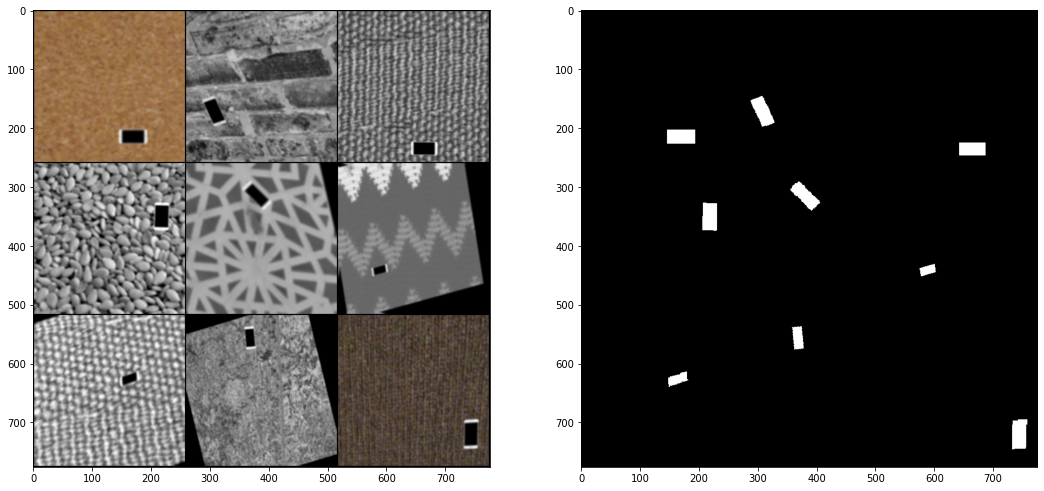

In [17]:
# Let's visualise some subset of the training set
sample_indices = np.random.choice(len(train_dataset), size=9, replace=False)
sample_images = []
sample_masks = []
for i in sample_indices:
    image, mask = train_dataset[i]
    sample_images.append(image)
    sample_masks.append(mask.unsqueeze(0))
    
plt.figure(figsize=(18, 18))
plt.subplot(121)
plt.imshow(torchvision.utils.make_grid(sample_images, nrow=3).permute(1, 2, 0).cpu().numpy())
plt.subplot(122)
plt.imshow(torchvision.utils.make_grid(sample_masks, nrow=3).permute(1, 2, 0).float().cpu().numpy())

### Step 3: Build dataloader, model and training modules which acts as engine/helper modules

### We will first write some helper modules to generate the model, load the data and run the training and validation 

In [18]:
! pip install segmentation-models-pytorch --quiet

     |████████████████████████████████| 97 kB 4.8 MB/s 
     |████████████████████████████████| 58 kB 5.1 MB/s 
     |████████████████████████████████| 376 kB 55.0 MB/s 


In [19]:
# Create model from smp - pytorch semantic segmentation models in pytorch

import segmentation_models_pytorch as smp

def create_model(output_channels: int = 1):
    """
    DeepLabv3 plus class with custom encoder and pretrained-weights
    Args:
        outputchannels (int, optional): The number of output channels
        in your dataset masks. Defaults to 1.
    Returns:
        model: Returns the Unet model with the chosen encoder.
    """

    model = smp.DeepLabV3Plus(
              encoder_name="efficientnet-b2",       # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
              encoder_weights="imagenet",     # use `imagenet` pre-trained weights for encoder initialization
              in_channels=3,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
              classes=output_channels,        # model output channels (number of classes in your dataset)
            )

    return model 

In [20]:
class DataModule:

  def __init__(
      self, 
      train_dataset, 
      val_dataset,
      batch_size: int = 4,
      **kwargs
      ):

    self.train_dataset = train_dataset
    self.val_dataset = val_dataset
    self.batch_size = batch_size

    if "num_workers" in kwargs:
      self.num_workers = kwargs["num_workers"]
    else:
      self.num_workers = 2

  @property
  def train_loader(self):
    return self._data_loader(
            dataset = self.train_dataset,
            shuffle = True, 
            num_worker = self.num_workers,
            batch_size = self.batch_size
    )
  @property              
  def val_loader(self):
    return self._data_loader(
            dataset = self.train_dataset,
            shuffle = False, 
            num_worker = 1,
            batch_size = 1
    )
      
  def _data_loader(
      self, 
      dataset : Dataset, 
      shuffle : bool = True, 
      num_worker : int = 2,
      batch_size: int = 4
  ) -> DataLoader :
  
    return DataLoader(
        dataset = dataset,
        shuffle = shuffle,
        batch_size = batch_size,
        num_workers = num_worker
    )

In [26]:
import torch
from torch.optim import lr_scheduler
import torch.optim as optim
import torch.nn as nn
import time
import copy

from collections import defaultdict

class MetricMonitor:

  def __init__(self):
    """Module to monitor traininig metric"""

    self.reset()

  def reset(self):
    self.metrics = defaultdict(lambda: {"val": 0, "count": 0, "avg": 0})

  def update(self, metric_name, val, counter_update = 1):
    metric = self.metrics[metric_name]

    metric["val"] += val
    metric["count"] += counter_update
    metric["avg"] = metric["val"] / metric["count"]


class EarlyStopping:

  def __init__(self, patience = 7, delta = 0, path ="best_model.pth"):
    """
    Early stops the training if validation loss doesn't improve after a given patience.
    Args:
        patience (int): How long to wait after last time validation loss improved.
        delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                        Default: 0   
        path (str) : Path to save the model
    """
    self.patience = patience
    self.counter = 0
    self.best_score = None
    self.early_stop = False
    self.val_loss_min = np.Inf
    self.delta = delta
    self.patience_mode = False

  def __call__(self, val_loss):

    score = -val_loss

    if self.best_score is None:
        self.best_score = score
    elif score < self.best_score + self.delta:
        self.patience_mode = True
        self.counter += 1
        if self.counter >= self.patience:
            self.early_stop = True
    else:
        self.patience_mode = False
        self.best_score = score
        self.counter = 0
        self.val_loss_min = val_loss


class Trainer():
    
  def __init__(self, model, datamodule, device, params):

    """
    Trainer engine to run training loops
    """
      
    self.model = model,
    self.datamodule = datamodule
    self.device = device
    self.params = params

    if isinstance(self.model, tuple):
      self.model = self.model[0]

    if "ce_weights" in self.params:
      weight = self.params["ce_weights"]
      weight = torch.FloatTensor(weight)
      weight = weight.to(self.device)
      self.criterion = nn.CrossEntropyLoss(weight=weight)
    else:
      self.criterion = nn.CrossEntropyLoss()

    self.optimizer = optim.SGD(self.model.parameters(), lr=0.001, momentum=0.9)
    self.scheduler = lr_scheduler.StepLR(self.optimizer, step_size=7, gamma=0.1)

    self.train_logs = {}
    self.val_logs = {}

  def train(self, epoch):

    """
    Run one epoch of training loop
    """
    metric_monitor = MetricMonitor()
    self.model.train()
    for i, (images, target) in enumerate(self.datamodule.train_loader):
        images = images.to(self.device, non_blocking=True)
        target = target.to(self.device, non_blocking=True)
        output = self.model(images)
        loss = self.criterion(output, target)

        _, preds = torch.max(output, 1)
        corrects = torch.sum(preds == target.data)

        metric_monitor.update("Loss", loss.item(), 1)
        metric_monitor.update("Accuracy", corrects, torch.numel(preds))
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()


    if (epoch - 1) % self.params["log_frequency"] == 0:
      print(
          "Training:  Loss: {loss_metric}, Pixel Accuracy: {accuracy_metric}".format(
                epoch=epoch,loss_metric=metric_monitor.metrics["Loss"]["avg"],
                accuracy_metric = metric_monitor.metrics["Accuracy"]["avg"])
      )

    self.train_logs[epoch] = {
        "epoch" : epoch,
        "loss" : metric_monitor.metrics["Loss"]["avg"],
        "pixel_accuracy" : metric_monitor.metrics["Accuracy"]["avg"]
    }

  def validate(self, epoch):

    """
    Run one epoch of validation loop
    """
      
    metric_monitor = MetricMonitor()
    self.model.eval()
    with torch.no_grad():
      for i, (images, target) in enumerate(self.datamodule.val_loader):
        images = images.to(self.device, non_blocking=True)
        target = target.to(self.device, non_blocking=True)

        output = self.model(images)
        loss = self.criterion(output, target)

        _, preds = torch.max(output, 1)
        corrects = torch.sum(preds == target.data)

        metric_monitor.update("Loss", loss.item())
        metric_monitor.update("Accuracy", corrects, torch.numel(preds))

    if (epoch - 1) % self.params["log_frequency"] == 0:
      print(
          "Validation:  Loss: {loss_metric}, Pixel Accuracy: {accuracy_metric}".format(
                epoch=epoch,loss_metric=metric_monitor.metrics["Loss"]["avg"],
                accuracy_metric = metric_monitor.metrics["Accuracy"]["avg"])
      )

    self.val_logs[epoch] = {
        "epoch" : epoch,
        "loss" : metric_monitor.metrics["Loss"]["avg"],
        "pixel_accuracy" : metric_monitor.metrics["Accuracy"]["avg"]
    }

  def train_and_validate(self, num_epochs):

    """
    Run multiple epochs of training and validation over the dataset
    """

    early_stopping = EarlyStopping(patience = 7, delta = 0.005)

    for epoch in range(1, num_epochs + 1):

      if (epoch - 1) % self.params["log_frequency"] == 0:
        log = True
      else:
        log = False

      if log:
        print("---------------------------------------")
        print("Epoch:  {epoch}".format(epoch = epoch))

      if early_stopping.early_stop is False:
        self.train(epoch)
        self.validate(epoch)
        early_stopping(self.val_logs[epoch]["loss"])
        if log:
          print("Best loss till now: {}".format(-early_stopping.best_score))
        if early_stopping.patience_mode is False:
          self.save_checkpoint()
          if log:
            print("Saving checkpoint at the epoch")
        else:
          if log:
            print("Patiently waiting for the loss to decrease")
      else:
        print("Early stopping at epoch : {}".format(epoch))
        print("Best loss till now: {}".format(-early_stopping.best_score))
        break

  def save_checkpoint(self, path = "best_model.pth"):
    """Saves model when validation loss decrease."""
    torch.save(self.model.state_dict(), path)

  def load_model(self, model_path = "best_model.pth"):
    """Loads the model from model path"""
    self.model.load_state_dict(torch.load(model_path))

In [22]:
class SemanticSegmenter():

  def __init__(
      self,
      model, 
      datamodule,
      params, 
      mode = "training",
      model_path = None
  ):

    """
    Initialise the model class
    Args:
        model: torch model class
        dataloader: datamodule containing train and val dataloader
        mode: "inference" or "training"
        params: dictionary of parameters for training
        model_path: path of  the model from where to load the trained model/
                    pretrained weights
    """

    self.model = model
    self.params = params

    if torch.cuda.is_available() and "cuda" in params["device"]: 
      self.device = torch.device(params["device"]) 
    else:
      self.device = torch.device("cpu")

    self.model = self.model.to(self.device)

    # Usually passed in inference mode 
    if model_path is not None:
      print("Loading model weights")
      self.model.load_state_dict(torch.load(model_path, map_location=self.device)) 

    # Load trainer only in training mode
    if mode == "training":
      self.datamodule = datamodule
      self.semantic_trainer = Trainer(self.model, self.datamodule, self.device, self.params)

  def train_and_test(self, num_epochs : int = 5):
    """
    Train the model given the number of epochs
    """

    # here you train your model
    self.semantic_trainer.train_and_validate(num_epochs)

  def plot_train_logs(self):

    # plot train and val logs
    train_logs = self.semantic_trainer.train_logs
    val_logs = self.semantic_trainer.val_logs

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(list(train_logs.keys()), [x["loss"] for x in train_logs.values()], color = "blue")
    plt.title("Train Loss Plot")
    plt.grid()
    plt.subplot(1, 2, 2)
    plt.plot(list(val_logs.keys()), [x["loss"] for x in val_logs.values()], color = "green")
    plt.title("Val Loss Plot")
    plt.grid()
    plt.show()
      
  def predict_single_image(self, image: Union[np.array, str], model_path: str = None):

    """
    Predict on a single image
    Args:
      image: numpy array of size of (H,W) or path to the image
    Returns:
      image_tensor, mask_tensor (torch.Tensor): tensors of size (H, W, 3) and (H, W)
    """

    if model_path is not None:
      self.model.load_model(model_path)

    self.model.eval()

    if isinstance(image, str):
      # open the image using PIL Image
      pil_image = Image.open(image)
    else:
      # convert to PIL image for resizing
      pil_image = Image.fromarray(image)
    
    # resize the image to dimensions of train image
    # alternatively we can pad as well
    pil_image = pil_image.resize(self.params["image_size"])
    image = np.array(pil_image)

    # convert to tensor image
    batch = T.ToTensor()(image).unsqueeze(0)
    batch = batch.to(self.device)

    with torch.no_grad():
      output = self.model(batch)

      # get probablity map
      prob_map = output.softmax(dim=1)
      prob_map = prob_map.squeeze(0)
      prob_map = prob_map.cpu().detach().numpy()

      # get output mask
      _ , pred_mask = torch.max(output,dim=1)
      pred_mask = pred_mask.cpu()

    return batch.squeeze(0).cpu(), pred_mask[0,:,:]

### Step 4: Initialise the modules and start the training 

In [31]:
params = {
    "num_epochs" : 15,
    "num_classes": 2,
    "batch_size": 4,
    "num_workers": 2,
    "log_frequency" : 1,
    "device" : "cuda",
    "image_size" : (256, 256),
    "ce_weights" : [1, 10]
}

In [27]:
# TODO: Implement and train the deep model

## initialise the model
model = create_model(output_channels = params["num_classes"])

## initialise the datamodule
datamodule = DataModule(train_dataset,
                        val_dataset,
                        batch_size = params["batch_size"],
                        num_workers = params["num_workers"]
                        )
## initialise the segmenter module
segmenter = SemanticSegmenter(model, datamodule, params)

In [28]:
## start the training
# params["num_epochs"]
segmenter.train_and_test(params["num_epochs"])

---------------------------------------
Epoch:  1
Training:  Loss: 0.0838206544316523, Pixel Accuracy: 0.9845840930938721
Validation:  Loss: 0.03784186031447726, Pixel Accuracy: 0.9953681230545044
Best loss till now: 0.03784186031447726
Saving checkpoint at the epoch
---------------------------------------
Epoch:  2
Training:  Loss: 0.030418781967535013, Pixel Accuracy: 0.9943096041679382
Validation:  Loss: 0.032507443021932016, Pixel Accuracy: 0.9954166412353516
Best loss till now: 0.032507443021932016
Saving checkpoint at the epoch
---------------------------------------
Epoch:  3
Training:  Loss: 0.02616089409606095, Pixel Accuracy: 0.9947837591171265
Validation:  Loss: 0.02600924476466689, Pixel Accuracy: 0.9960240125656128
Best loss till now: 0.02600924476466689
Saving checkpoint at the epoch
---------------------------------------
Epoch:  4
Training:  Loss: 0.022711068219929555, Pixel Accuracy: 0.9952477812767029
Validation:  Loss: 0.025642467901818893, Pixel Accuracy: 0.99599105

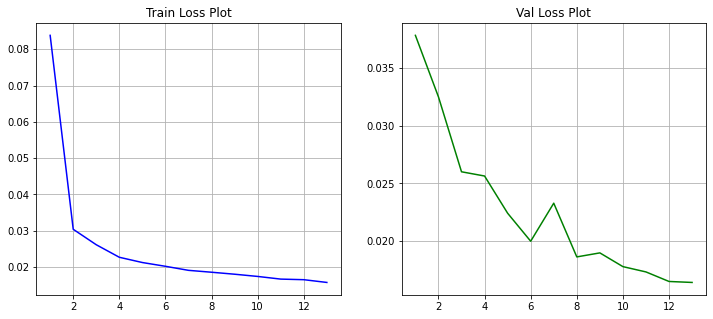

In [29]:
segmenter.plot_train_logs()

### Step 5: Inference Check

Take a random image from the test set and perform an inference over it

In [34]:
params = {
    "image_size" : (256, 256),
    "num_classes": 2,
    "device" : "cuda",
}

segmenter = SemanticSegmenter(model, None, params, mode = "inference", model_path = "best_model.pth")

Loading model weights


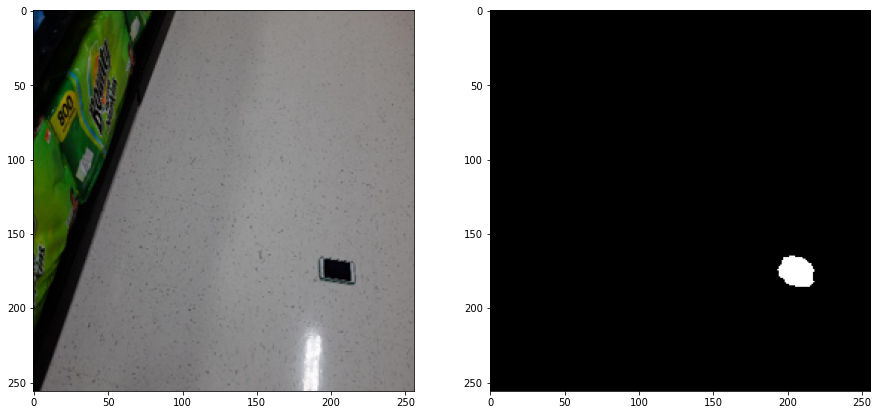

In [37]:
# sanity check

import random

test_image_path = random.choice(image_paths)
test_img_tensor, pred_tensor = segmenter.predict_single_image(test_image_path)

fig = plt.figure(figsize=(15,15))
ax = []
ax.append(fig.add_subplot(1, 2, 1))
ax.append(fig.add_subplot(1, 2, 2))

ax[0].imshow(test_img_tensor.numpy().transpose(1, 2, 0))
ax[1].imshow(pred_tensor, cmap  = "gray")

plt.show()

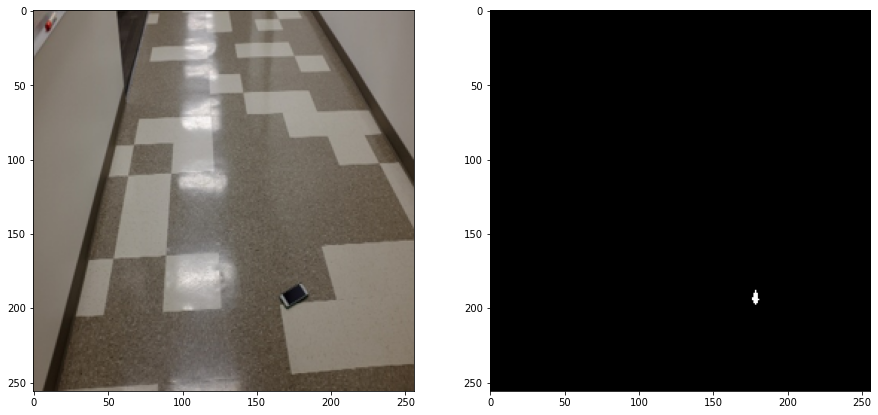

In [38]:
# sanity check

import random

test_image_path = random.choice(image_paths)
test_img_tensor, pred_tensor = segmenter.predict_single_image(test_image_path)

fig = plt.figure(figsize=(15,15))
ax = []
ax.append(fig.add_subplot(1, 2, 1))
ax.append(fig.add_subplot(1, 2, 2))

ax[0].imshow(test_img_tensor.numpy().transpose(1, 2, 0))
ax[1].imshow(pred_tensor, cmap  = "gray")

plt.show()